# SMART Health Cards

This notebook is designed to give an overview of [SMART Health Cards Framework](https://smarthealth.cards/) and how it works.


This notebook is written in JavaScript and uses the [IJavascript kernel](https://github.com/n-riesco/ijavascript) for Jupyter Notebook.

## Walkthrough

The high level outline is as follows:
* FHIR Bundle is created
* FHIR Bundle is minified
* SMART Health Card is created from FHIR Bundle
* SMART Health Card is encoded as a JWS
* Patient Retrieves the SMART Health Cards via:
  * File Download
  * QR Code
  * FHIR API

### The FHIR Bundle

A SMART Health Card is composed of a [W3C Verifiable Credential](https://w3c.github.io/vc-data-model/), [encoded as a JWT](https://w3c.github.io/vc-data-model/#jwt-encoding), with a Credential Subject that contains the FHIR version and a FHIR Bundle (See [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/).

The FHIR Bundle contains the health care information.

Let's assume we have the below FHIR Bundle ([Example 0](https://smarthealth.cards/examples/example-00-a-fhirBundle.json) at the time of writing). This FHIR Bundle could be produced in a number of ways, but for now let's imagine that the patient, John B. Anyperson, has just received his second COVID-19 vaccination shot and the healthcare worker entered his information into their system which produced the below in their system.

In [1]:
const fhirBundle = {
  "resourceType": "Bundle",
  "type": "collection",
  "entry": [
    {
      "fullUrl": "resource:0",
      "resource": {
        "resourceType": "Patient",
        "name": [
          {
            "family": "Anyperson",
            "given": [
              "John",
              "B."
            ]
          }
        ],
        "birthDate": "1951-01-20"
      }
    },
    {
      "fullUrl": "resource:1",
      "resource": {
        "resourceType": "Immunization",
        "status": "completed",
        "vaccineCode": {
          "coding": [
            {
              "system": "http://hl7.org/fhir/sid/cvx",
              "code": "207"
            }
          ]
        },
        "patient": {
          "reference": "resource:0"
        },
        "occurrenceDateTime": "2021-01-01",
        "performer": [
          {
            "actor": {
              "display": "ABC General Hospital"
            }
          }
        ],
        "lotNumber": "0000001"
      }
    },
    {
      "fullUrl": "resource:2",
      "resource": {
        "resourceType": "Immunization",
        "status": "completed",
        "vaccineCode": {
          "coding": [
            {
              "system": "http://hl7.org/fhir/sid/cvx",
              "code": "207"
            }
          ]
        },
        "patient": {
          "reference": "resource:0"
        },
        "occurrenceDateTime": "2021-01-29",
        "performer": [
          {
            "actor": {
              "display": "ABC General Hospital"
            }
          }
        ],
        "lotNumber": "0000007"
      }
    }
  ]
}

A couple things to note in the above JSON. This is a Bundle that contains 3 resources: one for the patient, one for the first vaccination, and another for the second vaccination. This Bundle conforms to the requirements laid out in [SMART Health Cards: Vaccination & Testing Implementation Guide](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/) which defines what resources should be included in the Health Card. Specifically, this is an example of [Vaccine Credential Bundle - Data Minimization](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/StructureDefinition-vaccine-credential-bundle-dm.html). We'll talk about what "Data Minimization" means in a second.

Now let's create the "Expanded Health Card".

### Expanded Health Card

The Expanded Health Card shows what the Health Card looks like before it is minified and serialized using the compact JWS serialization.

[Health Cards are encoded as Compact Serialization JSON Web Signatures (JWS)](https://smarthealth.cards/#health-cards-are-encoded-as-compact-serialization-json-web-signatures-jws) and [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/) cover this in more detail.

Before we get into the details it's important to note that some of the VC properties are mapped to standard JWT fields when using the [JWT encoding](https://w3c.github.io/vc-data-model/#jwt-encoding) (which we are). These include the `iss` and `nbf` fields.

Below shows the expanded Health Card for the example:

In [2]:
const expandedHealthCard = {
  "iss": "https://smarthealth.cards/examples/issuer",
  "nbf": Date.now() / 1000,
  "vc": {
    "@context": [
      "https://www.w3.org/2018/credentials/v1"
    ],
    "type": [
      "VerifiableCredential",
      "https://smarthealth.cards#health-card",
      "https://smarthealth.cards#immunization",
      "https://smarthealth.cards#covid19"
    ],
    "credentialSubject": {
        "fhirVersion": "4.0.1",
        "fhirBundle": fhirBundle
    }
  }
}

Let's talk about the three root fields:

`iss` - This represents the [Issuer](https://w3c.github.io/vc-data-model/#issuer)
  * Note this property is represented by `iss` according to the [JWT Encoding Rules](https://w3c.github.io/vc-data-model/#jwt-encoding)

`nbf` - This represents the [IssuanceDate](https://w3c.github.io/vc-data-model/#issuance-date)
  * Note this property is represented by `nbf`.

`vc` - This represents the VC claim minus all the unmapped fields (`iss` and `nbf`)


TODO: Fill out the rest of these properties

### Health Cards are Small

SMART Health Cards can be issued on pieces of paper via QR Codes. This introduces some unique size constraints in order to keep the number and size of QR codes manageable. When using and applying SMART Health Cards, it's important to keep them small.

The SMART Health Card spec requires that [the JWS payload is minified and compressed](https://smarthealth.cards/#health-cards-are-small) in order to reduce payload size.

SMART Health Cards are designed to be be atomic and shared as a whole. Information within the Health Card cannot be removed without affecting the verifiability of the Health Card. This imposes a privacy challenge when too much information is included in a single Health Card.

The "Data Minimization" profiles in the IG are designed to address these size and privacy concerns by ensuring the FHIR profiles only require the minimal set of information to achieve the desired results.

Below the JWS Payload (i.e. the "Expanded Health Card") is compressed according to the spec:

In [3]:
// Remove the optional whitespace
const noWhiteSpaceHealthCard = JSON.stringify(expandedHealthCard)
console.log(noWhiteSpaceHealthCard)

{"iss":"https://smarthealth.cards/examples/issuer","nbf":1644416073.642,"vc":{"@context":["https://www.w3.org/2018/credentials/v1"],"type":["VerifiableCredential","https://smarthealth.cards#health-card","https://smarthealth.cards#immunization","https://smarthealth.cards#covid19"],"credentialSubject":{"fhirVersion":"4.0.1","fhirBundle":{"resourceType":"Bundle","type":"collection","entry":[{"fullUrl":"resource:0","resource":{"resourceType":"Patient","name":[{"family":"Anyperson","given":["John","B."]}],"birthDate":"1951-01-20"}},{"fullUrl":"resource:1","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/sid/cvx","code":"207"}]},"patient":{"reference":"resource:0"},"occurrenceDateTime":"2021-01-01","performer":[{"actor":{"display":"ABC General Hospital"}}],"lotNumber":"0000001"}},{"fullUrl":"resource:2","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/si

In [4]:
// Normally we'd remove some of the fhirBundle elements at 
// this step ( e.g. Resource.id, Resource.meta, CodebableConcept.text).
// These are already missing from the original payload, so we'll skip that here

// Compress the payload with DEFLATE, omitting any zlib headers

const compressedPayload = zlib.deflateRawSync(noWhiteSpaceHealthCard)

### Creating the Signed Health Card

Now that we have the compressed payload we can sign it as a JWS. First, let's create the key pair for signing and verifying.

In [5]:
var jose = require('node-jose');

const keystore = jose.JWK.createKeyStore()

let signingKey;

keystore.generate("EC", "P-256").
        then(function(result) {
          // {result} is a jose.JWK.Key
          signingKey = result;
        });

In [6]:
// Print the entire key store, including the `d` member which contains the private key value
// Remove true to just present the public key
// See: https://tools.ietf.org/id/draft-jones-jose-json-private-and-symmetric-key-00.html#rfc.section.3.1.1
keystore.toJSON(true);

{
  keys: [
    {
      kty: 'EC',
      kid: 'Sdui1T7WKlBNaErX0c6Cuu31KjV0g3pbxLFXvfP5mkQ',
      crv: 'P-256',
      x: 'jy9fOp8MgnrUMIvNx5g3I54EYJeOrKxAZFjITnJlBto',
      y: 'Dpdk7YcJ1J0PGabanSYKpYL8fM84T-VJ9zmLdXvt3HA',
      d: 'RM_lMfMw5qGR8mvCuyeDaFAXiAz53GgtDLFj2ZXO4tk'
    }
  ]
}

With a signing key in hand we can create the JWS:

In [7]:
const fields = { zip: 'DEF' }

let jws;

jose.JWS.createSign({ format: 'compact', fields }, signingKey)
    .update(Buffer.from(compressedPayload))
    .final()
    .then(function(result) {
        jws = result;
        console.log(jws)
});

eyJ6aXAiOiJERUYiLCJhbGciOiJFUzI1NiIsImtpZCI6IlNkdWkxVDdXS2xCTmFFclgwYzZDdXUzMUtqVjBnM3BieExGWHZmUDVta1EifQ.3VJNj9MwEP0rq-HaJnG2bGlO0CLxcUBILFxQD64zbYwcO7KdtGWV_86M2y4g7fbECd_GfvPmved5AB0CVNDE2IUqz0MrfWxQmthkSvo65HiQbWcw5ATs0cME7GYLlbibzWbirpjfZnezcgKDguoBXitnIx4iVN8fKff7fba_zZzf5WUhXuXKY402amlCPghYTyAeO-SOb-j1VsuNwdUjhuY9q-3FqZhycRWn27a3-qeM2tmrQOUGXYsFi_ot80u_-YEqsr9toz2pDMxTwSwrMkF8fLvsbW2QMR6D673C--QKzg8Xl6CcMcR2UkID_JGsE3NvzFdvCHDprwoCXIoniD-THernD5Etnkhkqw3xwRtLGB_SjJ0e0HK8H13D9TKD9UgGN5rMv5WRucTipZgWYloWMI6TJ9WI62o-_B1xiDL2Idnl7YnIHzRIpbTFlasTg3K1trskPBxDxPa8h_QzjZmnheFk86DrXA0HIlCpE8piDuN6nEB3jiDJ2aJHy9r-TJBATqnepyc2e6_bE0WZDBdsi6LaOt_ScrMWqaLzTFnr0BmZ4lyubt6hRS_NzXsXOh1pMUcO0bj4qW833ApFOuLZBMv_MsFy8a8TnPPDSOcX.gKRKTEnu5mJfBdtjXpSAIc0kJ_3HpfAZAsxjrWh20XAGtPL1n5Jk2t4rN2KC_jOUFRbuFk_DTlQ82vlh6r18DQ


Now that we have the JWS we should check that we can actually verify the signature

In [8]:
jose.JWS.createVerify(signingKey)
    .verify(jws).then(function(result) {
    console.log(result)
})

{
  protected: [ 'zip', 'alg', 'kid' ],
  header: {
    zip: 'DEF',
    alg: 'ES256',
    kid: 'Sdui1T7WKlBNaErX0c6Cuu31KjV0g3pbxLFXvfP5mkQ'
  },
  payload: <Buffer dd 52 4d 8f d3 30 10 fd 2b ab e1 da 26 71 b6 6c 69 4e d0 22 f1 71 40 48 2c 5c 50 0f ae 33 6d 8c 1c 3b b2 9d b4 65 95 ff ce 8c db 2e 20 ed f6 c4 09 df ... 415 more bytes>,
  signature: <Buffer 80 a4 4a 4c 49 ee e6 62 5f 05 db 63 5e 94 80 21 cd 24 27 fd c7 a5 f0 19 02 cc 63 ad 68 76 d1 70 06 b4 f2 f5 9f 92 64 da de 2b 37 62 82 fe 33 94 15 16 ... 14 more bytes>,
  key: JWKBaseKeyObject {
    keystore: JWKStore {},
    length: 256,
    kty: 'EC',
    kid: 'Sdui1T7WKlBNaErX0c6Cuu31KjV0g3pbxLFXvfP5mkQ',
    use: '',
    alg: ''
  }
}


Let's also create a fake key and test with that to make sure we aren't getting a false positive

In [9]:
let fakeKey;

keystore.generate("EC", "P-256").
        then(function(result) {
          // {result} is a jose.JWK.Key
          fakeKey = result;
        });

In [10]:
// Note "Error: no key found" is the generic error message for keys that won't decrypt
// See: https://github.com/cisco/node-jose/issues/262
jose.JWS.createVerify(fakeKey)
    .verify(jws).then(function(result) {
    console.log(result)
})

Error: no key found

### QR Code Generation

Now that we have a JWS, we can turn that into a scannable QR Code. We do not need to worry about chunking just yet since the payload is below the 1195 character threshold in this example, but we will include the chunking code to show how the process works for larger examples.

As part of our design, we want to keep the `errorCorrectionLevel` to be `'low'`. 

In [11]:
const MAX_SINGLE_JWS_SIZE = 1195;
const MAX_CHUNK_SIZE = 1191;
const splitJwsIntoChunks = (jws) => {
  if (jws.length <= MAX_SINGLE_JWS_SIZE) {
    return [jws];
  }

  // Try to split the chunks into roughly equal sizes.
  const chunkCount = Math.ceil(jws.length / MAX_CHUNK_SIZE);
  const chunkSize = Math.ceil(jws.length / chunkCount);
  const chunks = jws.match(new RegExp(`.{1,${chunkSize}}`, 'g'));
  return chunks || [];
}

When encoding chunks as QR codes, we let `N` represent the total number of chunks required, and `C` represent the index of the current chunk. These values are appended to the fixed string `shc:/` of the QR code's `bytes` data segment so that we know what chunk the QR code represents. For example, if we have `N=3` chunks and are working with the second chunk (`C = 2`), the `bytes` segment of the QR code will begin with `shc:/2/3/`.

These chunking indices are omitted when `N = 1`, but we will include the code to show how the the segment is constructed for larger examples. In our example, the total number of chunks (`N`) is represented as `chunkCount` and the index of the current chunk (`C`) is represented as `jwsChunk`.

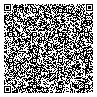

In [13]:
// Create array of chunks to convert into numeric mode QRs
var QRCode = require('qrcode')
const jwsChunks = splitJwsIntoChunks(jws);

// Save data from all generated QR Codes for future comparison with scanned QR Codes
let qrCodesData = [];

const obtainQRCodeData = async() => {
    const qrPromises = jwsChunks.map(async (jwsChunk, i) => {
        // This code snippet was adapted/taken from https://github.com/smart-on-fhir/health-cards/blob/152a4f83b223b5fd14027f765e957e290649f2c0/generate-examples/src/index.ts#L173
        const numericJWS = jwsChunk.split('')
            .map((c) => c.charCodeAt(0) - 45)
            .flatMap((c) => [Math.floor(c / 10), c % 10]) //Need to maintain leading zeros
            .join('')

        const segments = [
        // Add index of current chunk if there is more than one chunk
        // See https://spec.smarthealth.cards/#encoding-chunks-as-qr-codes for more information
        {data: 'shc:/' + ((jwsChunks.length > 1) ? `${jwsChunk + 1}/${chunkCount}/` : ``), mode: 'byte'},
        {data: numericJWS, mode: 'numeric'}
        ]

        let qrSVG
        // QR code version will default to smallest possible version
        await QRCode.toString(segments,{type: 'svg', errorCorrectionLevel: 'low'}).then(function(result){
            qrSVG = result
            $$.svg(qrSVG)
        });
        // Also print as PNG for scanning later on.
        QRCode.toFile(`./js_qrcode${i}.png`, segments, {width: 800})
        
        const qrCode = segments[0].data + segments[1].data
        return qrCode;
    });
    return await Promise.all(qrPromises);
}

obtainQRCodeData().then(results => {
    results.forEach(result => {
        qrCodesData.push(result);
    })
})

In [13]:
console.log(qrCodesData)

[
  'shc:/567629095243206034602924374044603122295953265460346029254077280433602870286471674522280928633362554262754123554338057522396425255463587444774523554340773240716841612165320621605624752642274564402341715204246057360106412933611232742435036968002752296526055326633403223175544021283125753623090777534474543410305571264241501109320576075810575324225550265773356473565508202103224133232405284068770332695742753664715962387366090827603653425474082039700354322410264431635360537742536069676157456556775458302358726621436071652875076041331157305757105753525077457757084240594372433044070305526463223558594439762056340038345300610441707233745540615972441268000625684559765437426505105206006856320571646936344026434470256050667111037250004424687069127166770567233275397438746932622511573173705342053632370923091006220000363077581143630922543254370540622823502926702406337377255573222723676974662243286665602300392756696523082471656259626874067574377131262150386129035603273011270406231239302312405826

The above shows what the value of the QR code will be, with the leading `byte` segment and the `numeric` segment following.

### QR Code Scanning

Now let's try and scan the QR Code!

In [14]:
var jsQR = require('jsqr');
var PNG = require('pngjs').PNG;

imageData = PNG.sync.read(fs.readFileSync('./js_qrcode0.png'))

const scannedQR = jsQR(new Uint8ClampedArray(imageData.data.buffer), imageData.width, imageData.height)

const qrCodesEqual = scannedQR.data === qrCodesData[0]

console.log("Are the QR Codes Equal? " + qrCodesEqual)

console.log(scannedQR.data)

Are the QR Codes Equal? true
shc:/567629095243206034602924374044603122295953265460346029254077280433602870286471674522280928633362554262754123554338057522396425255463587444774523554340773240716841612165320621605624752642274564402341715204246057360106412933611232742435036968002752296526055326633403223175544021283125753623090777534474543410305571264241501109320576075810575324225550265773356473565508202103224133232405284068770332695742753664715962387366090827603653425474082039700354322410264431635360537742536069676157456556775458302358726621436071652875076041331157305757105753525077457757084240594372433044070305526463223558594439762056340038345300610441707233745540615972441268000625684559765437426505105206006856320571646936344026434470256050667111037250004424687069127166770567233275397438746932622511573173705342053632370923091006220000363077581143630922543254370540622823502926702406337377255573222723676974662243286665602300392756696523082471656259626874067574377131262150386129035603273011

### Extracting Data from the QR Code

Now let's reverse the process to get the original data back and check the signature. First, let's extract the JWS.

In [15]:
const scannedJWS = scannedQR
    .chunks
    .filter(chunk => chunk.type === "numeric")[0] // Grab the numeric chunk
    .text.match(/(..?)/g) // Split into groups of 2 numeric characters each of which represent a single JWS char
    .map(num => String.fromCharCode(parseInt(num, 10) + 45)).join('') // Convert from numeric encoding to JWS

console.log(scannedJWS)

eyJ6aXAiOiJERUYiLCJhbGciOiJFUzI1NiIsImtpZCI6IlNkdWkxVDdXS2xCTmFFclgwYzZDdXUzMUtqVjBnM3BieExGWHZmUDVta1EifQ.3VJNj9MwEP0rq-HaJnG2bGlO0CLxcUBILFxQD64zbYwcO7KdtGWV_86M2y4g7fbECd_GfvPmved5AB0CVNDE2IUqz0MrfWxQmthkSvo65HiQbWcw5ATs0cME7GYLlbibzWbirpjfZnezcgKDguoBXitnIx4iVN8fKff7fba_zZzf5WUhXuXKY402amlCPghYTyAeO-SOb-j1VsuNwdUjhuY9q-3FqZhycRWn27a3-qeM2tmrQOUGXYsFi_ot80u_-YEqsr9toz2pDMxTwSwrMkF8fLvsbW2QMR6D673C--QKzg8Xl6CcMcR2UkID_JGsE3NvzFdvCHDprwoCXIoniD-THernD5Etnkhkqw3xwRtLGB_SjJ0e0HK8H13D9TKD9UgGN5rMv5WRucTipZgWYloWMI6TJ9WI62o-_B1xiDL2Idnl7YnIHzRIpbTFlasTg3K1trskPBxDxPa8h_QzjZmnheFk86DrXA0HIlCpE8piDuN6nEB3jiDJ2aJHy9r-TJBATqnepyc2e6_bE0WZDBdsi6LaOt_ScrMWqaLzTFnr0BmZ4lyubt6hRS_NzXsXOh1pMUcO0bj4qW833ApFOuLZBMv_MsFy8a8TnPPDSOcX.gKRKTEnu5mJfBdtjXpSAIc0kJ_3HpfAZAsxjrWh20XAGtPL1n5Jk2t4rN2KC_jOUFRbuFk_DTlQ82vlh6r18DQ


Next we can verify the signature and extract the payload

In [16]:
let scannedResult;

jose.JWS.createVerify(signingKey)
    .verify(scannedJWS).then(function(result) {
    zlib.inflateRaw(result.payload, function(err, decompressedResult){
        scannedResult = decompressedResult.toString('utf8')
    })
})

In [17]:
scannedResult

'{"iss":"https://smarthealth.cards/examples/issuer","nbf":1644416073.642,"vc":{"@context":["https://www.w3.org/2018/credentials/v1"],"type":["VerifiableCredential","https://smarthealth.cards#health-card","https://smarthealth.cards#immunization","https://smarthealth.cards#covid19"],"credentialSubject":{"fhirVersion":"4.0.1","fhirBundle":{"resourceType":"Bundle","type":"collection","entry":[{"fullUrl":"resource:0","resource":{"resourceType":"Patient","name":[{"family":"Anyperson","given":["John","B."]}],"birthDate":"1951-01-20"}},{"fullUrl":"resource:1","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/sid/cvx","code":"207"}]},"patient":{"reference":"resource:0"},"occurrenceDateTime":"2021-01-01","performer":[{"actor":{"display":"ABC General Hospital"}}],"lotNumber":"0000001"}},{"fullUrl":"resource:2","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/s

Let's compare this to our original minified payload with whitespace removed

In [18]:
scannedResult === noWhiteSpaceHealthCard

true

Finally, lets print the entries for easy inspection.

In [19]:
const entries = JSON.parse(scannedResult)
    .vc.credentialSubject.fhirBundle.entry
    .map(entry => console.log(JSON.stringify(entry, null, 2)))

{
  "fullUrl": "resource:0",
  "resource": {
    "resourceType": "Patient",
    "name": [
      {
        "family": "Anyperson",
        "given": [
          "John",
          "B."
        ]
      }
    ],
    "birthDate": "1951-01-20"
  }
}
{
  "fullUrl": "resource:1",
  "resource": {
    "resourceType": "Immunization",
    "status": "completed",
    "vaccineCode": {
      "coding": [
        {
          "system": "http://hl7.org/fhir/sid/cvx",
          "code": "207"
        }
      ]
    },
    "patient": {
      "reference": "resource:0"
    },
    "occurrenceDateTime": "2021-01-01",
    "performer": [
      {
        "actor": {
          "display": "ABC General Hospital"
        }
      }
    ],
    "lotNumber": "0000001"
  }
}
{
  "fullUrl": "resource:2",
  "resource": {
    "resourceType": "Immunization",
    "status": "completed",
    "vaccineCode": {
      "coding": [
        {
          "system": "http://hl7.org/fhir/sid/cvx",
          "code": "207"
        }
      ]
    },
